In [ ]:
%load_ext autoreload
%autoreload

In [16]:
#!pip install openai
!pip install openai==0.28

In [17]:
!pip install xlwt

In [18]:
import openai
import pandas as pd
import numpy as np
import json
import os
import time

openai.api_key = "your_key"
COMPLETIONS_MODEL = "gpt-4"

In [19]:
df = pd.read_csv('./test_data.csv')
size = len(df)
print(size)

1994


In [20]:
df.head(10)

,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2018-19224,An issue was discovered in LAOBANCMS 2.0. /adm...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,CVE-2019-11091,Microarchitectural Data Sampling Uncacheable M...,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,CVE-2019-2459,Vulnerability in the Oracle Outside In Technol...,0,0,0,1,1,1,1,0,0,1,0,0,0,0
3,CVE-2018-5390,Linux kernel versions 4.9+ can be forced to ma...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,CVE-2017-14710,"The Shein Group Ltd. ""SHEIN - Fashion Shopping...",0,1,0,0,0,0,1,0,0,0,0,0,0,0
5,CVE-2018-19248,The web service on Epson WorkForce WF-2861 10....,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,CVE-2020-3803,Adobe Acrobat and Reader versions 2020.006.200...,0,0,0,0,1,1,0,0,0,0,0,0,0,0
7,CVE-2013-0632,"administrator.cfc in Adobe ColdFusion 9.0, 9.0...",0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,CVE-2019-9848,LibreOffice has a feature where documents can ...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,CVE-2021-22894,A buffer overflow vulnerability exists in Puls...,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [21]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered

In [22]:
df.head(5)

,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2018-19224,An issue was discovered in LAOBANCMS 2.0. /adm...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,CVE-2019-11091,Microarchitectural Data Sampling Uncacheable M...,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,CVE-2019-2459,Vulnerability in the Oracle Outside In Technol...,0,0,0,1,1,1,1,0,0,1,0,0,0,0
3,CVE-2018-5390,Linux kernel versions 4.9+ can be forced to ma...,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,CVE-2017-14710,"The Shein Group Ltd. ""SHEIN - Fashion Shopping...",0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
def request_completion(prompt):
    message=[{"role": "system", "content": prompt}]
    time.sleep(1)
    completion_response = openai.ChatCompletion.create(
      model=COMPLETIONS_MODEL,
      messages = message,
      temperature=0.2,
      max_tokens=1000,
      frequency_penalty=0.0
    )

    return completion_response

In [24]:
zero_shot_prompt_long = '''You are a cybersecurity researcher. You receive the description of a vulnerability (CVE) and you map it to one of the 14 MITRE tactics.
The tactics and their descriptions are:
Reconnaissance - gather information they can use to plan future operations
Resource Development - establish resources they can use to support operations
Initial Access - get into your network
Execution - run malicious code
Persistence - maintain their foothold
Privilege Escalation - gain higher-level permissions
Defense Evasion - avoid being detected
Credential Access - steal account names and passwords
Discovery - figure out your environment
Lateral Movement - move through your environment
Collection - gather data of interest to their goal
Exfiltration - steal data
Command and Control - communicate with compromised systems to control them
Impact - manipulate, interrupt, or destroy your systems and data

The prediction must have the following format [predicted_tactic, predicted_tactic, ..]

CVE_DESCRIPTION: TEXT

The classification:'''

In [25]:
zero_shot_prompt_short = '''You are a cybersecurity researcher. You receive the description of a vulnerability (CVE) and you map it to one of the 14 MITRE tactics.
The tactics are:
Resource Development
Initial Access
Execution
Persistence
Privilege Escalation
Defense Evasion
Credential Access
Discovery
Lateral Movement
Collection
Exfiltration
Command and Control
Impact
Reconnaissance

The prediction must have the following format [predicted_tactic, predicted_tactic, ..]

CVE_DESCRIPTION: TEXT

The classification:'''

In [26]:
def get_ohe(x):
    labels_li = [' '.join(x.split()) for x in df.columns.to_list()[2:]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx

    x = x.replace("[", "")
    x = x.replace("]", "")

    x = x.replace("'", "")
    x = x.replace('"', "")

    y = x.split(',')
    y = [label.lstrip() for label in y]

    ohe = []

    temp = [0] * 14
    for label in y:
      idx = labels_li_indices.get(label, -1)
      if idx != -1:
        temp[idx] = 1

    return temp

In [27]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report
)

from sklearn.metrics import (
    recall_score,
    precision_score
)

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  sorted_results.head()
  return sorted_results.iloc[:, :limit]


def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [28]:
true_all = []
predicted_all = []

for i in range (0, len(df)):
  entry = df.iloc[i]

  prompt = zero_shot_prompt_short.replace('TEXT', entry['Text'])
  print(entry['Text'])

  try:
    completion_response = request_completion(prompt)
  except Exception as e:
    print(f"An error occurred: {e}")
    continue

  response = completion_response['choices'][0]['message']['content']
  print(response)

  encoding = get_ohe(response)
  print(encoding)

  true = entry[2:].tolist()
  print(true)

  predicted_all.append(encoding)
  true_all.append(true)

  print("------------")

preds = np.array(predicted_all)
trues = np.array(true_all)

Streaming output truncated to the last 5000 lines.
The OpenID Single Sign-On authentication functionality in OXID eShop before 4.5.0 allows remote attackers to impersonate users via the email address in a crafted authentication token.
[Initial Access, Credential Access]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
------------
A vulnerability in Cisco IOS XE Software could allow an unauthenticated, remote attacker to log in to a device running an affected release of Cisco IOS XE Software with the default username and password that are used at initial boot, aka a Static Credential Vulnerability. The vulnerability is due to an undocumented user account with privilege level 15 that has a default username and password. An attacker could exploit this vulnerability by using this account to remotely connect to an affected device. A successful exploit could allow the attacker to log in to the device with privilege level 15 access. This vulnerability aff

In [29]:
df = pd.DataFrame(preds)
output_file = 'gpt4_zero_shot_short.xls'
df.to_excel(output_file, index=False)

<ipython-input-29-4187ac8a13c6>:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(output_file, index=False)


In [30]:
val_weighted_f1_score = f1_score(trues, preds, average='weighted')
print('Val weighted f1 score:', val_weighted_f1_score)

Val weighted f1 score: 0.28998942683093454


In [31]:
val_micro_f1_score = f1_score(trues, preds, average='micro')
print('Val micro f1 score:', val_micro_f1_score)

Val micro f1 score: 0.3014861995753716


In [32]:
val_macro_f1_score = f1_score(trues, preds, average='macro')
print('Val macro f1 score:', val_macro_f1_score)

Val macro f1 score: 0.22048709742700587


In [33]:
print('Val accuracy:', accuracy_score(trues, preds))
print('Val precision:', precision_score(trues, preds, average='weighted'))
print('Val recall:', recall_score(trues, preds, average='weighted'))

Val accuracy: 0.028084252758274825
Val precision: 0.5142973508363509
Val recall: 0.29571012078300707


In [34]:
df = df_filtered

In [35]:
print("F1 Score per class")
f1_metrics = compute_metrics(preds, trues, f1_score, df.columns[2:], 14)

F1 Score per class


In [36]:
f1_metrics.head()

,Discovery,Privilege Escalation,Exfiltration,Execution,Defense Evasion,Credential Access,Initial Access,Impact,Reconnaissance,Collection,Command and Control,Persistence,Lateral Movement,Resource Development
0,0.633894,0.574578,0.512821,0.362121,0.277023,0.229008,0.149281,0.1331,0.068182,0.067925,0.039801,0.028986,0.010101,0.0


In [37]:
print("Accuracy Score per class")
acc_metrics = compute_metrics(preds, trues, accuracy_score, df.columns[2:], 14)

Accuracy Score per class


In [38]:
print(acc_metrics.head())

   Reconnaissance  Resource Development  Initial Access  Execution  \
0        0.028084              0.028084        0.028084   0.028084   

   Persistence  Privilege Escalation  Defense Evasion  Credential Access  \
0     0.028084              0.028084         0.028084           0.028084   

   Discovery  Lateral Movement  Collection  Command and Control  Exfiltration  \
0   0.028084          0.028084    0.028084             0.028084      0.028084   

     Impact  
0  0.028084  


In [39]:
print("Precision Score per class")
precision_metrics = compute_metrics(preds, trues, precision_score, df.columns[2:], 14)

Precision Score per class


In [40]:
precision_metrics.head()

,Discovery,Defense Evasion,Persistence,Privilege Escalation,Exfiltration,Execution,Lateral Movement,Credential Access,Initial Access,Impact,Collection,Reconnaissance,Command and Control,Resource Development
0,0.819398,0.770393,0.5,0.493318,0.361446,0.301768,0.2,0.149626,0.085744,0.075848,0.068182,0.055556,0.034483,0.0


In [41]:
print("Recall Score per class")
recall_metrics = compute_metrics(preds, trues, recall_score, df.columns[2:], 14)

Recall Score per class


In [42]:
print(recall_metrics.head())

   Exfiltration  Privilege Escalation  Initial Access    Impact  Discovery  \
0      0.882353              0.687888        0.576389  0.542857   0.516878   

   Credential Access  Execution  Defense Evasion  Reconnaissance  Collection  \
0           0.487805   0.452652         0.168874        0.088235    0.067669   

   Command and Control  Persistence  Lateral Movement  Resource Development  
0             0.047059     0.014925          0.005181                   0.0  


In [43]:
prev_df = pd.read_csv('./test_data.csv')
size = len(prev_df)

In [44]:
distribution = prev_df.drop(prev_df.columns[0:2], axis=1)

In [45]:
distribution.head()

,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,1,1,1,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,0,0,0,0


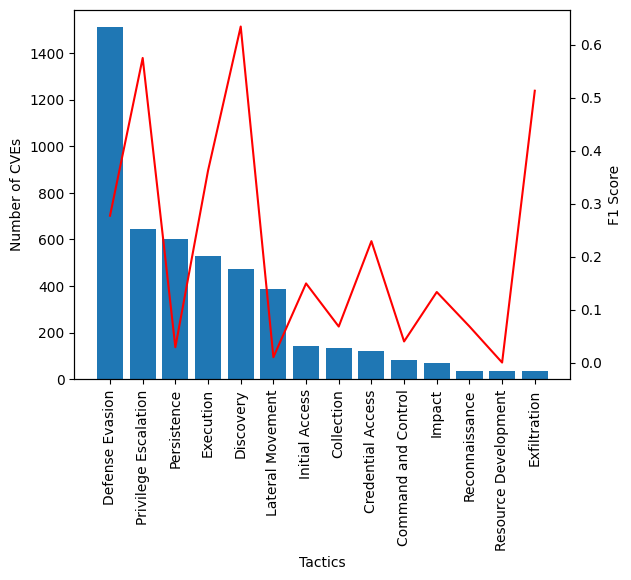

In [46]:
print_F1_based_on_distribution(preds, trues, distribution,  df.columns[2:])